## Overview

The basic idea of Decision Trees isn't hard to grok-- indeed following the flow-chart of decision criteria is why they're considered one of the more powerful algorithms from an interpretability standpoint.

We'll cover actually building the tree below. So skipping ahead, after we've constructed our tree we wind up with `m` neat rectangles in some many-dimensional space. It's important to note that when we're done, every single data point-- trained or new-- maps directly onto one of these `m` rectangles.

Finally, from a prediction standpoint, when we get a new `X`, we trace through the tree and figure out which rectangle it lands in, then make the prediction:

- Classification: Pick the class with the most representation in the rectangle/terminal node
- Regression: Return the average value of `y` for the training data that generated this rectangle/terminal node

## Building Tree

When we construct our Decision Tree, we only split on one variable at a time, per layer. Overall, our goal is to maximize the *information gain* at each split.

Thus at each stage, it looks roughly like

``` python
for feature in features:
    if is_continuous(feature):
        # actual split value generation varies by implementation
        # e.g. height (in) might try every 5 in between min and max
        lots_of_splits = get_splits(data[feature])
        
        best_split, best_loss_value = check_continuous_splits(
                                         data, feature, lots_of_splits)
    
    elif is_categorical(feature):
        best_split = []
        best_loss_value = []
        
        # for (A, B, C): A vs B+C, B vs A+C, C vs A+B
        checks = generate_one_vs_many(data[feature])
        
        for check in checks:
            loss_value = calculate_loss(split_on_check(data, feature))
            if loss_value < best_loss_value:
                best_split = check
                best_loss_value = loss_value
                
new_tree = tree.split_on(best_split)

# recursively do this step until you've organized your tree
            
```

Going back to this notion of "make a bunch of multi-dimensional rectangles", we can define half-planes `R_1` and `R_2` as

$R_1(j, s): \{X|X<s\}$

$R_2(j, s): \{X|X\geq s\}$

That account for all points that fall within `R` for feature `j`, split at the value `s`

### Objective Functions

The Objective Function that you're trying to minimize throughout Tree construction depends, obviously, on whether or not you're working on a Classification or Regression problem.

The Regression form should look familiar:

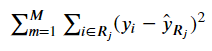

In [1]:
from IPython.display import Image

Image('images/regression_cost.PNG')

Classification, on the other hand, can take a few different forms.

Because our predictions are based on the majority class in any terminal node, our loss/objective functions will all be based on `pHat_mk`, the proportion of the majority class `k` in node `m`. However, because I already know LaTeX will throw a fit if I try and put `mk` in the underscore, we'll refer to this variable as `rho`.

And so the most basic function we could come up with is the *error rate*, the probability that we see another class in this terminal node.

$E = 1 - max_k(\rho)$

#### Advanced Classification Loss Functions

The two most popular loss functions for classification introduce more sensitivity to the diversity of class representation in each node.

To illustrate that, let's construct a few simple hypothetical nodes, `proportions`, of *decreasing* diversity, and examine their effects on the loss functions.

In [2]:
import numpy as np

proportions = np.array(
               [[0.0, 0.0, 0.0, 0.0, 1.0],
                [0.1, 0.0, 0.0, 0.0, 0.9],
                [0.0, 0.0, 0.0, 0.5, 0.5],
                [0.33, 0.33, 0.33, 0.0, 0.0],
                [0.25, 0.25, 0.25, 0.0, 0.25],
                [0.2, 0.2, 0.2, 0.2, 0.2]])

# make zero vals basically zero for clean log-work
proportions = np.clip(proportions, 1e-12, None)

The *Gini Index* (the default loss function in `sklearn`) is defined by

$G = \sum_{k=1}^{K} \rho(1 - \rho)$

Throwing our dummy data at it, we get

In [3]:
for prop in proportions:
    gini = np.sum([(x * (1 - x)) for x in prop])
    print(f'{gini:.5f}')

0.00000
0.18000
0.50000
0.66330
0.75000
0.80000


Looking at the equation, it should be a no-brainer why our first `proportions` list yielded a straight-zero score, and increased as we had less-clear separation.

**Note**: The Gini Index is more-commonly referred to as the *node purity*

Another popular loss function is [*Categorical Cross Entropy*](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html), which should be second-nature to anyone doing multiclass Deep Learning.

Again, plugging our data in yields a clear increase in values as our dataset becomes less separated.

In [4]:
for prop in proportions:
    entropy = np.sum([-(x * np.log(x)) for x in prop])
    print(f'{entropy:.5f}')

0.00000
0.32508
0.69315
1.09758
1.38629
1.60944


### Stopping Conditions

Obviously, if the construction of our trees is done in a recursive fashion, we need some sort of break condition.

There are a number of things that we might consider in this regard. Drawing from the docstring of `sklearn.tree.DecisionTreeClassifier` we can get a brief rundown of our options and their defaults

```
max_depth : int or None, optional (default=None)
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until all leaves contain less than
    min_samples_split samples.

min_samples_split : int, float, optional (default=2)
    The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a fraction and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.

min_samples_leaf : int, float, optional (default=1)
    The minimum number of samples required to be at a leaf node.
    A split point at any depth will only be considered if it leaves at
    least ``min_samples_leaf`` training samples in each of the left and
    right branches.  This may have the effect of smoothing the model,
    especially in regression.

    - If int, then consider `min_samples_leaf` as the minimum number.
    - If float, then `min_samples_leaf` is a fraction and
      `ceil(min_samples_leaf * n_samples)` are the minimum
      number of samples for each node.

max_features : int, float, string or None, optional (default=None)
    The number of features to consider when looking for the best split:

        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a fraction and
          `int(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)`.
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.

max_leaf_nodes : int or None, optional (default=None)
    Grow a tree with ``max_leaf_nodes`` in best-first fashion.
    Best nodes are defined as relative reduction in impurity.
    If None then unlimited number of leaf nodes.

min_impurity_decrease : float, optional (default=0.)
    A node will be split if this split induces a decrease of the impurity
    greater than or equal to this value.
```

In general, though it's important to note that setting most of these to `None` and hitting Go will amount to this Tree perfectly overfitting our data-- a trait obviously undesirable in any model.

Few options here:

- Intelligently apply constraints via Cross Validation/Grid Searching
- [Prune our over-fit trees](https://napsterinblue.github.io/notes/machine_learning/trees/decision_tree_pruning/)
- Move onto Tree-based ensemble methods

On that last point, we consider the tradeoff between model performance and interpretability-- we can either have a neat flow-chart of decision making, or a potentially-vague "variable importance" score across arbitrarily-many models.